# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

C:\Users\sowmya\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:14<00:00, 1867.72it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [24]:
final['preprocessed_text']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...



<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Summary'].values[4900]
print(sent_4900)
print("="*50)

EVERY book is educational
Shipment was expired by 2 years
Would be best if Canola Oil was left out
Best SF Syrup on the market!


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

EVERY book is educational


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

EVERY book is educational
Shipment was expired by 2 years
Would be best if Canola Oil was left out
Best SF Syrup on the market!


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_1500 = decontracted(sent_1000)
print(sent_1500)
print("="*50)

Shipment was expired by 2 years


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_1000).strip()
print(sent_1000)

Shipment was expired by 2 years


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Shipment was expired by 2 years


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

  0%|                                                                           | 176/364171 [00:00<03:46, 1609.59it/s]C:\Users\sowmya\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
  6%|████▍                                                                    | 22344/364171 [00:11<02:17, 2493.92it/s]C:\Users\sowmya\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 10%|███████▏                                                                 | 35922/364171 [00:17<02:40, 2041.95it/s]C:\Users\sowmya\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandl

In [34]:
preprocessed_summary[4900]

'best sf syrup market'

In [35]:
final['preprocessed_summary']=preprocessed_summary
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_text,preprocessed_summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months


In [36]:
#sorting data based on time
#reference:https://pandas.pydata.org/pandas-docs/version/0.22/10min.html
final_data=final.sort_values(by = "Time")
print(final_data.shape)
final_data.head(5)

(364171, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_text,preprocessed_summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,whole series great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,entertainingl funny
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,modern day fairy tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,fantastic


# [4] Featurization

In [37]:
#dividin date into train,test,cross validation before converting in to vectors to avoid data lekage

data=final_data[0:100000]
print(data.shape)
data.head(3)
y=data['Score'].values
x=data['preprocessed_text'].values
# create training and testing vars
X_traincv, X_test, y_traincv, y_test = train_test_split(x, y, test_size=0.2)
print (X_traincv.shape, y_traincv.shape)
print (X_test.shape, y_test.shape)

(100000, 12)
(80000,) (80000,)
(20000,) (20000,)


## [4.1] BAG OF WORDS

In [38]:
#BoW
import warnings
warnings.filterwarnings("ignore")
from scipy.sparse import csr_matrix
import scipy.sparse
from scipy.sparse import coo_matrix, hstack
m=X_traincv.T
o=X_test.T
count_vect = CountVectorizer() #in scikit-learn
BOW_counts=count_vect.fit_transform(m)
print(BOW_counts.shape)
X_len=np.array([len(x) for x in X_traincv]).reshape(-1,1)
print(X_len.shape)
BOW_countsl=hstack([BOW_counts,X_len])
x_lentest=np.array([len(x) for x in X_test]).reshape(-1,1)
print(x_lentest.shape)
BOW_counts_test= count_vect.transform(o)
BOW_counts_testl=hstack([BOW_counts_test,x_lentest])

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*100)

#data preprocssing:standardize the data
from sklearn.preprocessing import StandardScaler#(xi-mui/sigmai)
BOW_countsl=StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(BOW_countsl)
BOW_counts_testl=StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(BOW_counts_testl)
print("the type of count vectorizer ",type(BOW_countsl))
print("the shape of out text BOW vectorizer ",BOW_countsl.get_shape())
print("the number of unique words ", BOW_countsl.get_shape()[1])
print("the type of count vectorizer ",type(BOW_counts_testl))
print("the shape of out text BOW vectorizer ",BOW_counts_testl.get_shape())
print("the number of unique words ", BOW_counts_testl.get_shape()[1])

(80000, 52922)
(80000, 1)
(20000, 1)
some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaah', 'aaaaah', 'aaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (80000, 52923)
the number of unique words  52923
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 52923)
the number of unique words  52923


In [39]:
s=BOW_countsl.astype('float32')
print(type(s))
s.data+=0.001

<class 'scipy.sparse.csr.csr_matrix'>


## [4.2] Bi-Grams and n-Grams.

#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [40]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(m)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(m)
final_tf_idf_test = tf_idf_vect.transform(o)
final_tf_idf=StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(final_tf_idf)
final_tf_idf_test=StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(final_tf_idf_test)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
print('='*50)
print('='*50)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'ab', 'abandon', 'abandoned', 'abc', 'abdominal', 'ability', 'able', 'able brew', 'able buy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (80000, 44872)
the number of unique words including both unigrams and bigrams  44872
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 44872)
the number of unique words including both unigrams and bigrams  44872


## [4.4] Word2Vec

In [41]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in m:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8476577401161194), ('fantastic', 0.8449395895004272), ('terrific', 0.8360322713851929), ('awesome', 0.8225774765014648), ('excellent', 0.8189431428909302), ('wonderful', 0.7745852470397949), ('perfect', 0.7555155754089355), ('nice', 0.7067368030548096), ('decent', 0.6839704513549805), ('amazing', 0.6657446622848511)]
[('greatest', 0.7847483158111572), ('best', 0.765052855014801), ('nastiest', 0.7076218128204346), ('tastiest', 0.6921259164810181), ('disgusting', 0.625365138053894), ('coolest', 0.6161469221115112), ('nicest', 0.6077620983123779), ('smoothest', 0.6024051308631897), ('terrible', 0.5878893136978149), ('superior', 0.5860752463340759)]


In [43]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16995
sample words  ['not', 'aware', 'fruition', 'tried', 'new', 'strawberry', 'flavor', 'expected', 'hard', 'chew', 'granola', 'type', 'bar', 'hate', 'snacks', 'thought', 'would', 'hand', 'husband', 'use', 'pig', 'soon', 'opened', 'one', 'could', 'smell', 'dates', 'yummy', 'found', 'firm', 'soft', 'really', 'tasty', 'appreciate', 'natural', 'low', 'calories', 'etc', 'bars', 'hunger', 'hit', 'stopping', 'eat', 'option', 'probar', 'took', 'away', 'job', 'physically', 'demanding']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [44]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 80000/80000 [04:25<00:00, 301.58it/s]


80000
50


In [45]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_test=[]
for sentance in o:
    list_of_sentance_test.append(sentance.split())

In [46]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:06<00:00, 300.50it/s]


20000
50


#### [4.4.1.2] TFIDF weighted W2v

In [47]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(m)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [48]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 80000/80000 [1:03:46<00:00, 20.91it/s]


In [49]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [14:22<00:00, 23.18it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

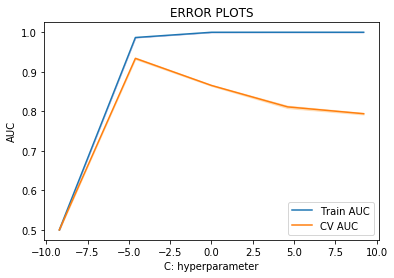

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.9868018807042145
0.9390119373515581


In [50]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
import math
lr = LogisticRegression(penalty='l1',class_weight='balanced')
#parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
clf = GridSearchCV(lr, tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(BOW_countsl, y_traincv)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
P=[10**-4, 10**-2, 10**0, 10**2, 10**4]
C=[]
for i in P:
    C.append(math.log(i))
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print(clf.best_estimator_)
print(clf.score(BOW_countsl, y_traincv))
print(clf.score(BOW_counts_testl, y_test))
print('='*200)
score_train_bowl1=clf.score(BOW_countsl, y_traincv)
score_test_bowl1=clf.score(BOW_counts_testl, y_test)

In [51]:
print(list(cv_auc))
print(list(P))

[0.5, 0.93394346283569, 0.8654384995101904, 0.8111831000831957, 0.7939483940929405]
[0.0001, 0.01, 1, 100, 10000]


In [52]:
i=list(cv_auc).index(max(cv_auc))
optimal_C_bowl1=P[i]
print(optimal_C_bowl1)

0.01


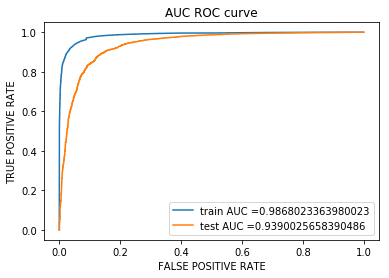

In [53]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
we=LogisticRegression(C=optimal_C_bowl1,penalty='l1',class_weight='balanced')
we.fit(BOW_countsl,y_traincv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_traincv, we.predict_proba(BOW_countsl)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, we.predict_proba(BOW_counts_testl)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("AUC ROC curve")
plt.show()

print("="*100)
train_AUC_bowl1 = auc(train_fpr, train_tpr)
test_AUC_bowl1 = auc(test_fpr, test_tpr)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [54]:
# Please write all the code with proper documentation
import numpy as np
we=LogisticRegression(C=optimal_C_bowl1,penalty='l1',class_weight='balanced')
we.fit(BOW_countsl,y_traincv)
W=we.coef_
print(np.count_nonzero(W))

6242


In [55]:
W=W+10**-6

#### CONFUSION MATRIX obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [56]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_traincv, we.predict(BOW_countsl))
cm_test=confusion_matrix(y_test, we.predict(BOW_counts_testl))

Train confusion matrix


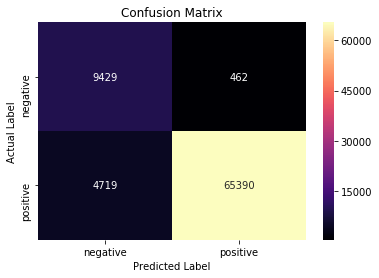

In [57]:
print("Train confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_train, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

Test confusion matrix


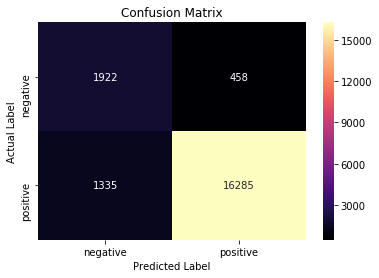

In [58]:
print("Test confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

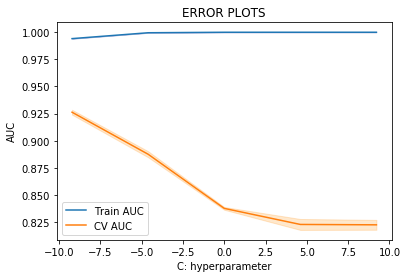

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.9933908682215346
0.9340313480670361


In [59]:
# Please write all the code with proper documentation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2',class_weight='balanced')
#parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
clf = GridSearchCV(lr, tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(BOW_countsl, y_traincv)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
P=[10**-4, 10**-2, 10**0, 10**2, 10**4]
C=[]
for i in P:
    C.append(math.log(i))
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print(clf.best_estimator_)
print(clf.score(BOW_countsl, y_traincv))
print(clf.score(BOW_counts_testl, y_test))
print('='*200)
score_train_bowl2=clf.score(BOW_countsl, y_traincv)
score_test_bowl2=clf.score(BOW_counts_testl, y_test)

In [60]:
print(list(cv_auc))
print(P)

[0.9262621259080306, 0.8875159402732592, 0.837617281374357, 0.8227983507051704, 0.8224460820369596]
[0.0001, 0.01, 1, 100, 10000]


In [61]:
i=list(cv_auc).index(max(cv_auc))
optimal_C_bowl2=P[i]
print(optimal_C_bowl2)

0.0001


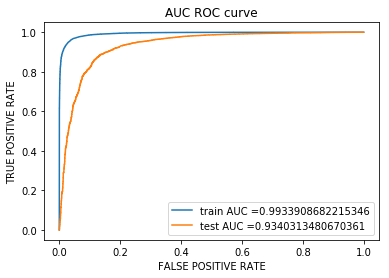

In [62]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
we=LogisticRegression(C=optimal_C_bowl2,penalty='l2',class_weight='balanced')
we.fit(BOW_countsl,y_traincv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_traincv, we.predict_proba(BOW_countsl)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, we.predict_proba(BOW_counts_testl)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("AUC ROC curve")
plt.show()

print("="*100)
train_AUC_bowl2 = auc(train_fpr, train_tpr)
test_AUC_bowl2 = auc(test_fpr, test_tpr)

In [154]:
# Please write all the code with proper documentation
import numpy as np
we=LogisticRegression(C=optimal_C_bowl2,penalty='l2',class_weight='balanced')
we.fit(BOW_countsl,y_traincv)
W=we.coef_
print(np.count_nonzero(W))

52923


In [155]:
W

array([[-0.00191209,  0.0032982 ,  0.00240426, ...,  0.00061797,
         0.00137879,  0.04110567]])

In [167]:
We=W+10**-6

In [168]:
print(We)

[[-0.00191109  0.0032992   0.00240526 ...  0.00061897  0.00137979
   0.04110667]]


#### CONFUSION MATRIX obtained using L2 regularization on BOW,<font color='red'> SET 1</font>

In [157]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_traincv, we.predict(BOW_countsl))
cm_test=confusion_matrix(y_test, we.predict(BOW_counts_testl))

Train confusion matrix


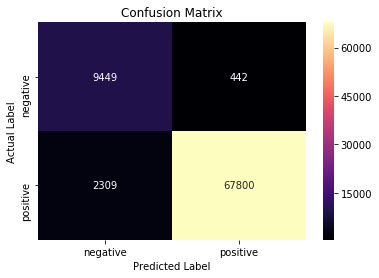

In [158]:
print("Train confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_train, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

Test confusion matrix


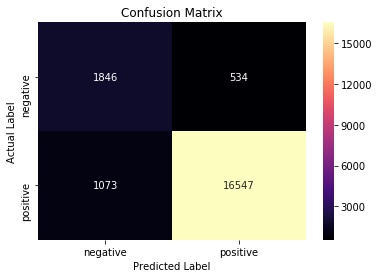

In [159]:
print("Test confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [160]:
# Please write all the code with proper documentation
import numpy as np
we=LogisticRegression(C=1,penalty='l1',class_weight='balanced')
we.fit(s,y_traincv)
Wn=we.coef_
print(np.count_nonzero(Wn))

15165


In [161]:
wd=Wn+10**-6

In [162]:
print(Wn)

[[0.00000000e+00 4.30316234e-02 3.62929536e-04 ... 0.00000000e+00
  1.40649699e-02 7.44078160e-01]]


In [163]:
per=(abs((We-wd)/We)*100)
print(type(per))

<class 'numpy.ndarray'>


In [164]:
print(Wn.size)

52923


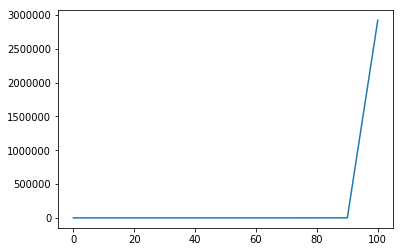

In [178]:
y=[np.percentile(per,0),np.percentile(per,10),np.percentile(per,20),np.percentile(per,30),np.percentile(per,40),np.percentile(per,50),np.percentile(per,60),np.percentile(per,70),np.percentile(per,80),np.percentile(per,90),np.percentile(per,100)]
x=[0,10,20,30,40,50,60,70,80,90,100]

plt.plot(x,y)

In [179]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html
print(per[np.where(per > 90)].size)

49922


49922 feautures have  weight change greater than 90 percent.hence feautures are multicolinnear.

In [181]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
feature_names = count_vect.get_feature_names()
print(feature_names[49922:])

['valuecalories', 'valued', 'valueonly', 'values', 'valuesaturated', 'valuetrans', 'valuevitamin', 'valve', 'valved', 'valves', 'vamp', 'vampire', 'vampires', 'van', 'vanalla', 'vancouver', 'vanes', 'vanessa', 'vaniila', 'vanila', 'vanilla', 'vanillaand', 'vanillachange', 'vanillamilkshake', 'vanillanumi', 'vanillas', 'vanille', 'vaniller', 'vanillery', 'vanillia', 'vanillin', 'vanish', 'vanished', 'vanishing', 'vanity', 'vannila', 'vannilla', 'vanquish', 'vantiquities', 'vapor', 'vaporize', 'vaporized', 'vaporizer', 'vaporizes', 'vapors', 'vaporub', 'vaposteam', 'var', 'varaities', 'vareties', 'varety', 'variability', 'variable', 'variables', 'variance', 'variances', 'variant', 'variants', 'variation', 'variations', 'variaty', 'varicose', 'varied', 'variedly', 'varieities', 'varies', 'variescalories', 'varietal', 'varietals', 'varietes', 'varietials', 'varieties', 'varietiesand', 'variety', 'varietyof', 'varietys', 'variey', 'varing', 'various', 'variously', 'variousseasonings', 'vari

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [74]:
# Please write all the code with proper documentation
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
feature_names = count_vect.get_feature_names()
coefs_with_fns = sorted(zip(we.coef_[0], feature_names))
top = coefs_with_fns[:-11:-1]
print("Top 10 positive features/n")
for coef_1, positive in top:
    print ("\t%.4f\t%-15s" % (coef_1, positive))
    

Top 10 positive features/n
	2.3857	great          
	1.7227	best           
	1.5577	good           
	1.5255	perfect        
	1.4927	love           
	1.3590	favorite       
	1.2444	healthful      
	1.1497	loves          
	1.1406	addicted       
	1.1341	delicious      


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [75]:
# Please write all the code with proper documentation
feature_names = count_vect.get_feature_names()
coefs_with_fns = sorted(zip(we.coef_[0], feature_names))
top = coefs_with_fns[:10]
print("Top 10 Negative features")
for coef_1, negative in top:
    print ("\t%.4f\t%-15s" % (coef_1, negative))

Top 10 Negative features
	-2.8569	not            
	-1.4388	worst          
	-0.9928	canidae        
	-0.8821	bait           
	-0.7555	superfine      
	-0.7156	unfortunately  
	-0.7140	disappointing  
	-0.6969	terrible       
	-0.6792	geyser         
	-0.6298	leaves         


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

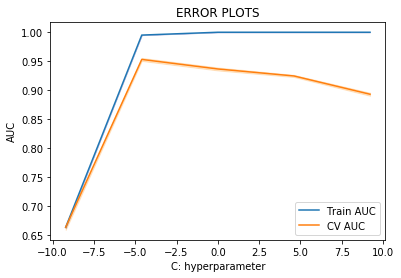

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.9951099016536522
0.9573656749873616


In [76]:
# Please write all the code with proper documentation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
import math
lr = LogisticRegression(penalty='l1',class_weight='balanced')
#parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
clf = GridSearchCV(lr, tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(final_tf_idf, y_traincv)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
P=[10**-4, 10**-2, 10**0, 10**2, 10**4]
C=[]
for i in P:
    C.append(math.log(i))
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print(clf.best_estimator_)
print(clf.score(final_tf_idf, y_traincv))
print(clf.score(final_tf_idf_test, y_test))
print('='*200)
score_train_tfidfl1=clf.score(final_tf_idf, y_traincv)
score_test_tfidfl1=clf.score(final_tf_idf_test, y_test)

In [77]:
print(list(cv_auc))
print(list(P))

[0.6638306447129373, 0.9531485819683566, 0.9366891069218433, 0.9246459263833312, 0.8931439402393008]
[0.0001, 0.01, 1, 100, 10000]


In [78]:
i=list(cv_auc).index(max(cv_auc))
optimal_C_tfidfl1=P[i]
print(optimal_C_tfidfl1)

0.01


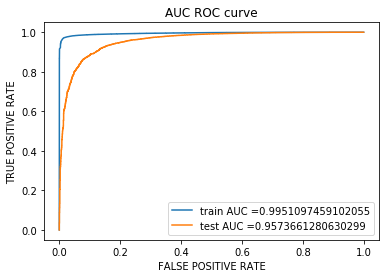

In [79]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
we=LogisticRegression(C=optimal_C_tfidfl1,penalty='l1',class_weight='balanced')
we.fit(final_tf_idf,y_traincv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_traincv, we.predict_proba(final_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, we.predict_proba(final_tf_idf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("AUC ROC curve")
plt.show()

print("="*100)
train_AUC_tfidfl1 = auc(train_fpr, train_tpr)
test_AUC_tfidfl1 = auc(test_fpr, test_tpr)

#### CONFUSION MATRIX obtained using L1 regularization on TFIDF,<font color='red'> SET 1</font>

In [80]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_traincv, we.predict(final_tf_idf))
cm_test=confusion_matrix(y_test, we.predict(final_tf_idf_test))

Train confusion matrix


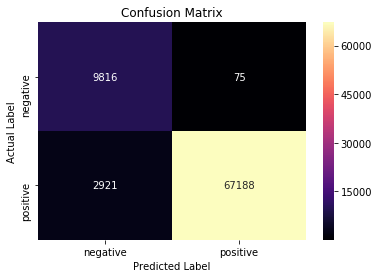

In [81]:
print("Train confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_train, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

Test confusion matrix


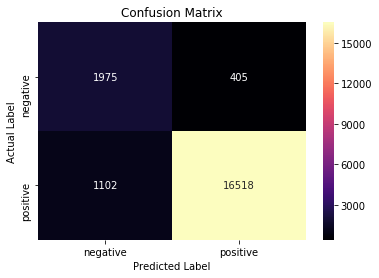

In [82]:
print("Test confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

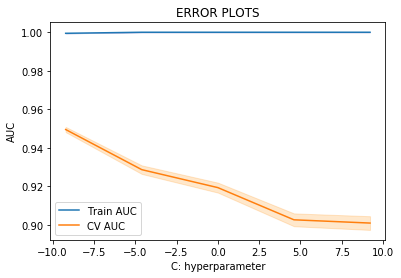

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.9991751480978492
0.9540213923253751


In [83]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
import math
lr = LogisticRegression(penalty='l2',class_weight='balanced')
#parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
clf = GridSearchCV(lr, tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(final_tf_idf, y_traincv)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
P=[10**-4, 10**-2, 10**0, 10**2, 10**4]
C=[]
for i in P:
    C.append(math.log(i))
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print(clf.best_estimator_)
print(clf.score(final_tf_idf, y_traincv))
print(clf.score(final_tf_idf_test, y_test))
print('='*200)
score_train_tfidfl2=clf.score(final_tf_idf, y_traincv)
score_test_tfidfl2=clf.score(final_tf_idf_test, y_test)

In [84]:
print(list(cv_auc))
print(list(P))

[0.9495211710026759, 0.9287012708009627, 0.9193841080050035, 0.9026809892172394, 0.9009902488638578]
[0.0001, 0.01, 1, 100, 10000]


In [85]:
i=list(cv_auc).index(max(cv_auc))
optimal_C_tfidfl2=P[i]
print(optimal_C_tfidfl2)

0.0001


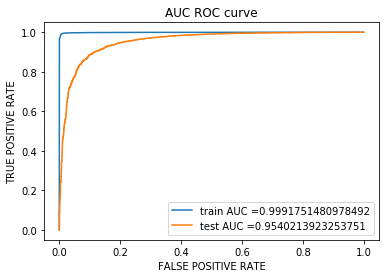

In [86]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
we=LogisticRegression(C=optimal_C_tfidfl2,penalty='l2',class_weight='balanced')
we.fit(final_tf_idf,y_traincv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_traincv, we.predict_proba(final_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, we.predict_proba(final_tf_idf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("AUC ROC curve")
plt.show()

print("="*100)
train_AUC_tfidfl2= auc(train_fpr, train_tpr)
test_AUC_tfidfl2 = auc(test_fpr, test_tpr)

In [87]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_traincv, we.predict(final_tf_idf))
cm_test=confusion_matrix(y_test, we.predict(final_tf_idf_test))

Train confusion matrix


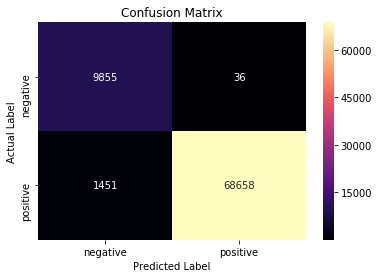

In [88]:
print("Train confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_train, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

Test confusion matrix


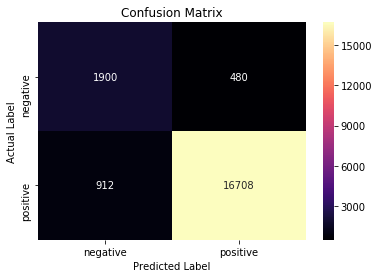

In [89]:
print("Test confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [90]:
# Please write all the code with proper documentation
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
feature_names = tf_idf_vect.get_feature_names()
coefs_with_fns = sorted(zip(we.coef_[0], feature_names))
top = coefs_with_fns[:-11:-1]
print("Top 10 positive features/n")
for coef_1, positive in top:
    print ("\t%.4f\t%-15s" % (coef_1, positive))
    

Top 10 positive features/n
	0.1179	great          
	0.0881	best           
	0.0802	love           
	0.0767	good           
	0.0714	delicious      
	0.0587	loves          
	0.0576	excellent      
	0.0558	wonderful      
	0.0544	perfect        
	0.0517	favorite       


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [91]:
# Please write all the code with proper documentation
feature_names = tf_idf_vect.get_feature_names()
coefs_with_fns = sorted(zip(we.coef_[0], feature_names))
top = coefs_with_fns[:10]
print("Top 10 Negative features")
for coef_1, negative in top:
    print ("\t%.4f\t%-15s" % (coef_1, negative))

Top 10 Negative features
	-0.0701	disappointed   
	-0.0695	worst          
	-0.0691	not worth      
	-0.0608	not            
	-0.0582	not good       
	-0.0580	terrible       
	-0.0577	not recommend  
	-0.0569	disappointing  
	-0.0565	horrible       
	-0.0564	not buy        


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

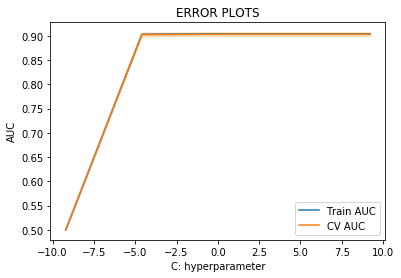

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.9040889373297154
0.9058051035397132


In [92]:
# Please write all the code with proper documentation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
import math
lr = LogisticRegression(penalty='l1',class_weight='balanced')
#parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
clf = GridSearchCV(lr, tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(sent_vectors, y_traincv)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
P=[10**-4, 10**-2, 10**0, 10**2, 10**4]
C=[]
for i in P:
    C.append(math.log(i))
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print(clf.best_estimator_)
print(clf.score(sent_vectors, y_traincv))
print(clf.score(sent_vectors_test, y_test))
print('='*200)
score_train_aw2vl1=clf.score(sent_vectors, y_traincv)
score_test_aw2vl1=clf.score(sent_vectors_test, y_test)

In [93]:
print(list(cv_auc))
print(list(P))

[0.5, 0.9026600816396474, 0.9033550168753658, 0.9033484765144131, 0.903348599076072]
[0.0001, 0.01, 1, 100, 10000]


In [94]:
i=list(cv_auc).index(max(cv_auc))
optimal_C_aw2vl1=P[i]
print(optimal_C_aw2vl1)

1


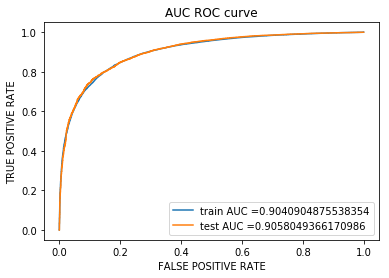

In [95]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
we=LogisticRegression(C=optimal_C_aw2vl1,penalty='l1',class_weight='balanced')
we.fit(sent_vectors,y_traincv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_traincv, we.predict_proba(sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, we.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("AUC ROC curve")
plt.show()

print("="*100)
train_AUC_aw2vl1 = auc(train_fpr, train_tpr)
test_AUC_aw2vl1= auc(test_fpr, test_tpr)

#### [5.1.1.1] CONFUSION MATRIX obtained using L1 regularization on AVE W2V,<font color='red'> SET 1</font>

In [96]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_traincv, we.predict(sent_vectors))
cm_test=confusion_matrix(y_test, we.predict(sent_vectors_test))

Train confusion matrix


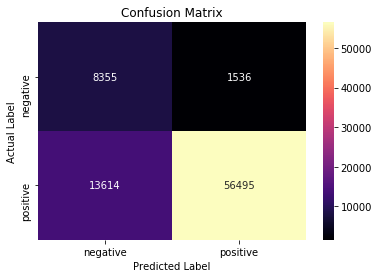

In [97]:
print("Train confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_train, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

Test confusion matrix


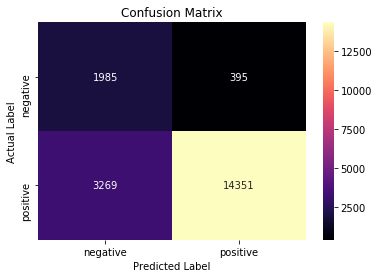

In [98]:
print("Test confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

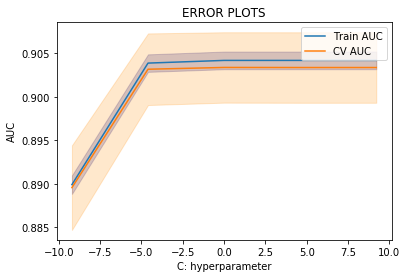

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.9040903664200437
0.9058116850599491


In [99]:
# Please write all the code with proper documentation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
import math
lr = LogisticRegression(penalty='l2',class_weight='balanced')
#parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
clf = GridSearchCV(lr, tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(sent_vectors, y_traincv)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
P=[10**-4, 10**-2, 10**0, 10**2, 10**4]
C=[]
for i in P:
    C.append(math.log(i))
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print(clf.best_estimator_)
print(clf.score(sent_vectors, y_traincv))
print(clf.score(sent_vectors_test, y_test))
print('='*200)
score_train_aw2vl2=clf.score(sent_vectors, y_traincv)
score_test_aw2vl2=clf.score(sent_vectors_test, y_test)

In [100]:
print(list(cv_auc))
print(list(P))

[0.889565094713594, 0.9031480579431471, 0.9033521392408181, 0.9033433930676823, 0.903343465151909]
[0.0001, 0.01, 1, 100, 10000]


In [101]:
i=list(cv_auc).index(max(cv_auc))
optimal_C_aw2vl2=P[i]
print(optimal_C_aw2vl2)

1


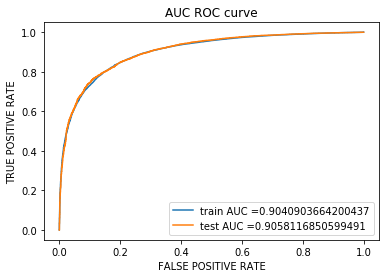

In [102]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
we=LogisticRegression(C=optimal_C_aw2vl2,penalty='l2',class_weight='balanced')
we.fit(sent_vectors,y_traincv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_traincv, we.predict_proba(sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, we.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("AUC ROC curve")
plt.show()

print("="*100)
train_AUC_aw2vl2 = auc(train_fpr, train_tpr)
test_AUC_aw2vl2= auc(test_fpr, test_tpr)

#### [5.1.1.1] CONFUSION MATRIX obtained using L2 regularization on AVE W2V,<font color='red'> SET 1</font>

In [103]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_traincv, we.predict(sent_vectors))
cm_test=confusion_matrix(y_test, we.predict(sent_vectors_test))

Train confusion matrix


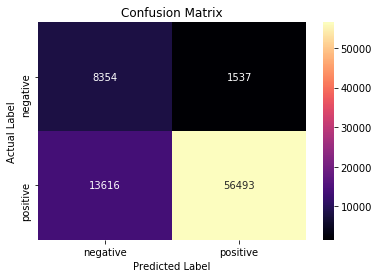

In [104]:
print("Train confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_train, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

Test confusion matrix


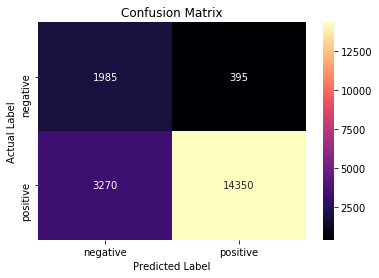

In [105]:
print("Test confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

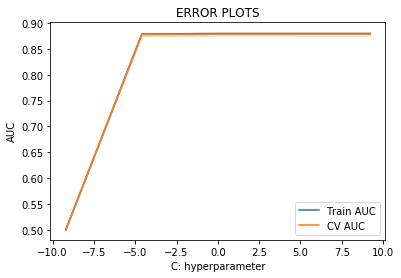

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.8794615390686495
0.8806993222941844


In [106]:
# Please write all the code with proper documentation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
import math
lr = LogisticRegression(penalty='l1',class_weight='balanced')
#parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
clf = GridSearchCV(lr, tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(tfidf_sent_vectors, y_traincv)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
P=[10**-4, 10**-2, 10**0, 10**2, 10**4]
C=[]
for i in P:
    C.append(math.log(i))
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print(clf.best_estimator_)
print(clf.score(tfidf_sent_vectors, y_traincv))
print(clf.score(tfidf_sent_vectors_test, y_test))
print('='*200)
score_train_tfidfaw2vl1=clf.score(tfidf_sent_vectors, y_traincv)
score_test_tfidfaw2vl1=clf.score(tfidf_sent_vectors_test, y_test)

In [107]:
print(list(cv_auc))
print(list(P))

[0.5, 0.8777758557575777, 0.8785701710387435, 0.8785628168031809, 0.8785624637464867]
[0.0001, 0.01, 1, 100, 10000]


In [108]:
i=list(cv_auc).index(max(cv_auc))
optimal_C_tfidfw2vl1=P[i]
print(optimal_C_tfidfw2vl1)

1


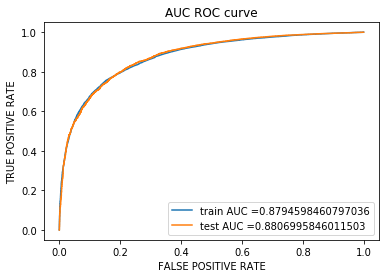

In [109]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
we=LogisticRegression(C=optimal_C_tfidfw2vl1,penalty='l1',class_weight='balanced')
we.fit(tfidf_sent_vectors,y_traincv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_traincv, we.predict_proba(tfidf_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, we.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("AUC ROC curve")
plt.show()

print("="*100)
train_AUC_tfidfw2vl1 = auc(train_fpr, train_tpr)
test_AUC_tfidfw2vl1= auc(test_fpr, test_tpr)

#### [5.1.1.1] CONFUSION MATRIX obtained using L1 regularization on TFIDF W2V,<font color='red'> SET 1</font>

In [110]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_traincv, we.predict(tfidf_sent_vectors))
cm_test=confusion_matrix(y_test, we.predict(tfidf_sent_vectors_test))

Train confusion matrix


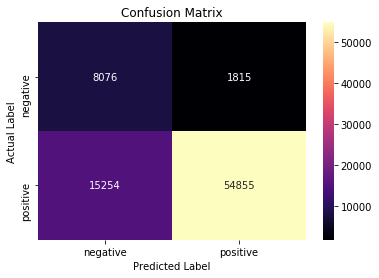

In [111]:
print("Train confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_train, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

Test confusion matrix


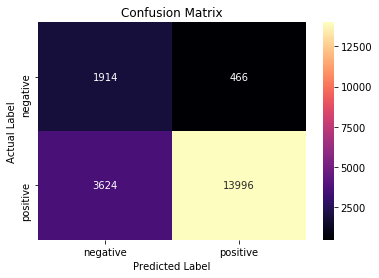

In [112]:
print("Test confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

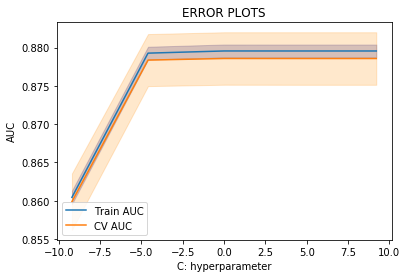

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.8794525593053054
0.8807020407481948


In [113]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
import math
lr = LogisticRegression(penalty='l2',class_weight='balanced')
#parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
clf = GridSearchCV(lr, tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(tfidf_sent_vectors, y_traincv)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
P=[10**-4, 10**-2, 10**0, 10**2, 10**4]
C=[]
for i in P:
    C.append(math.log(i))
plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print(clf.best_estimator_)
print(clf.score(tfidf_sent_vectors, y_traincv))
print(clf.score(tfidf_sent_vectors_test, y_test))
print('='*200)
score_train_tfidfaw2vl2=clf.score(tfidf_sent_vectors, y_traincv)
score_test_tfidfaw2vl2=clf.score(tfidf_sent_vectors_test, y_test)

In [114]:
print(list(cv_auc))
print(list(P))

[0.8598794080699322, 0.8783569602902677, 0.8785661484802253, 0.878562564611636, 0.8785625357104003]
[0.0001, 0.01, 1, 100, 10000]


In [115]:
i=list(cv_auc).index(max(cv_auc))
optimal_C_tfidfw2vl2=P[i]
print(optimal_C_tfidfw2vl2)

1


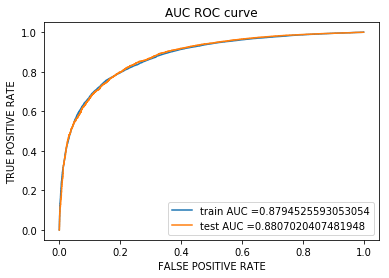

In [116]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
we=LogisticRegression(C=optimal_C_tfidfw2vl2,penalty='l2',class_weight='balanced')
we.fit(tfidf_sent_vectors,y_traincv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_traincv, we.predict_proba(tfidf_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, we.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("AUC ROC curve")
plt.show()

print("="*100)
train_AUC_tfidfw2vl2 = auc(train_fpr, train_tpr)
test_AUC_tfidfw2vl2= auc(test_fpr, test_tpr)

#### [5.1.1.1] CONFUSION MATRIX obtained using L2 regularization on TFIDF W2V,<font color='red'> SET 1</font>

In [117]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_traincv, we.predict(tfidf_sent_vectors))
cm_test=confusion_matrix(y_test, we.predict(tfidf_sent_vectors_test))

Train confusion matrix


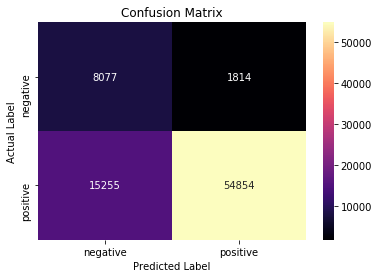

In [118]:
print("Train confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_train, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

Test confusion matrix


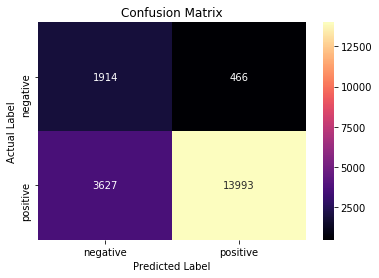

In [119]:
print("Test confusion matrix")
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index = class_label, columns = class_label)
sns.heatmap(df_cm, cmap='magma',annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# [6] Conclusions

In [128]:
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["GRIDSEARCHCVMODEL"," BESTHyperparameter(C)","roc_auc on train data","roc_auc on test data","PENALTY","TRAIN_AUC","TEST_AUC"]

x.add_row(["LR_BOW",round(optimal_C_bowl1,2),round(score_train_bowl1,2),round(score_test_bowl1,2),'L1',round(train_AUC_bowl1,2),round(test_AUC_bowl1,2)])
x.add_row(["LR_BOW",round(optimal_C_bowl2,2),round(score_train_bowl2,2),round(score_test_bowl2,2),'L2',round(train_AUC_bowl2,2),round(test_AUC_bowl2,2)])
x.add_row(["LR_TFIDF",round(optimal_C_tfidfl1,2),round(score_train_tfidfl1,2),round(score_test_tfidfl1,2),'L1',round(train_AUC_tfidfl1,2),round(test_AUC_tfidfl1,2)])
x.add_row(["LR_TFIDF",round(optimal_C_tfidfl2,2),round(score_train_tfidfl2,2),round(score_test_tfidfl2,2),'L2',round(train_AUC_tfidfl2,2),round(test_AUC_tfidfl2,2)])
x.add_row(["LR_AVGW2V",round(optimal_C_aw2vl1,2),round(score_train_aw2vl1,2),round(score_test_aw2vl1,2),'L1',round(train_AUC_aw2vl1,2),round(test_AUC_aw2vl1,2)])
x.add_row(["LR_AVGW2V",round(optimal_C_aw2vl2,2),round(score_train_aw2vl2,2),round(score_test_aw2vl2,2),'L2',round(train_AUC_aw2vl2,2),round(test_AUC_aw2vl2,2)])
x.add_row(["LR_TFIDFW2V",round(optimal_C_tfidfw2vl1,2),round(score_train_tfidfaw2vl1,2),round(score_test_tfidfaw2vl1,2),'L1',round(train_AUC_tfidfw2vl1,2),round(test_AUC_tfidfw2vl1,2)])
x.add_row(["LR_TFIDFW2V",round(optimal_C_tfidfw2vl2,2),round(score_train_tfidfaw2vl2,2),round(score_test_tfidfaw2vl2,2),'L2',round(train_AUC_tfidfw2vl2,2),round(test_AUC_tfidfw2vl2,2)])

print(x)

+-------------------+------------------------+-----------------------+----------------------+---------+-----------+----------+
| GRIDSEARCHCVMODEL |  BESTHyperparameter(C) | roc_auc on train data | roc_auc on test data | PENALTY | TRAIN_AUC | TEST_AUC |
+-------------------+------------------------+-----------------------+----------------------+---------+-----------+----------+
|       LR_BOW      |          0.01          |          0.99         |         0.94         |    L1   |    0.99   |   0.94   |
|       LR_BOW      |          0.0           |          0.99         |         0.93         |    L2   |    0.99   |   0.93   |
|      LR_TFIDF     |          0.01          |          1.0          |         0.96         |    L1   |    1.0    |   0.96   |
|      LR_TFIDF     |          0.0           |          1.0          |         0.95         |    L2   |    1.0    |   0.95   |
|     LR_AVGW2V     |           1            |          0.9          |         0.91         |    L1   |    0.9 

#  observations

# steps followed in presentin data

#1)Logistic regression algorithm is apllied on the preprocessed text of reviews from amazon fine food data by converting it 
  it into bag of words , tfidf,ave w2v,tfidf w2v model.
#2)a feauture engineering hack is performed to improve the performance of model by appending length of reviews as another          feature for bow model.
#3)sparsity of weight vector is caluculated using l1 regularization for optimal_c on bag of words model.
#4)petrubation test is performed on the model by adding noise to bow to check for multicolinearity of features. 
#5)hyper parameter tuning is performed by using gridsearchcv and clf.best_estimator_ attribute is used to find best C.
#6)optimal C is used to predict the fpr and tpr of train and test data at different threshholds
#7)Using fpr and tpr values AUROC curve is plotted.
#8)Area under AUROC curve gives us the probabilty that given a query point to how much extent it  is correctly classified.
#9)top 10 important features from both positive and negatave classes are reported by using  attribute coef_.
#10)then confusion matrix is plotted by using heat maps for both train and test data.
